## Import modules

In [138]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torch.autograd import Variable
import time
import torchvision.models as models
import os

## Load dataset

In [118]:
# CIFAR10 Test dataset and dataloader declaration
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Load model

In [152]:
# Define what device we are using
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the network
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 10)

# freeze front layers
ct = 0
for child in model.children():
    ct += 1
    if ct < 5:
        for param in child.parameters():
            param.requires_grad = False
model = model.to(device)
# model.eval()

CUDA Available:  True


## Train 

In [153]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=30)
criterion = nn.CrossEntropyLoss()

In [154]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [155]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    total = 0
    correct = 0
    
    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        target = target.to(device)
        input = input.to(device)
        target_var = target

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # measure accuracy and record loss
        _, predicted = output.max(1)
        losses.update(loss.item(), input.size(0))
        total += target.size(0)
        correct += predicted.eq(target).sum().item()


        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 50 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Accuracy {acc:.3f}'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, acc=correct/total))


In [156]:
def save_checkpoint(state,filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

In [157]:
global best_prec1
best_prec1 = 0

for epoch in range(50):

    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(trainloader, model, criterion, optimizer, epoch)
    lr_scheduler.step()

    if epoch > 0 and epoch % 50 == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict()
        },  filename=os.path.join('./checkpoints/', 'checkpoint.th'))

    save_checkpoint({
        'state_dict': model.state_dict()
    },  filename=os.path.join('./checkpoints/', 'model.th'))

current lr 1.00000e-02
Epoch: [0][0/391]	Time 0.217 (0.217)	Data 0.160 (0.160)	Loss 2.4019 (2.4019)	Accuracy 0.062
Epoch: [0][50/391]	Time 0.046 (0.050)	Data 0.002 (0.005)	Loss 1.4891 (1.9398)	Accuracy 0.318
Epoch: [0][100/391]	Time 0.047 (0.048)	Data 0.002 (0.004)	Loss 1.3389 (1.6404)	Accuracy 0.428
Epoch: [0][150/391]	Time 0.048 (0.048)	Data 0.002 (0.003)	Loss 0.9509 (1.4635)	Accuracy 0.487
Epoch: [0][200/391]	Time 0.050 (0.047)	Data 0.002 (0.003)	Loss 0.8998 (1.3371)	Accuracy 0.532
Epoch: [0][250/391]	Time 0.046 (0.047)	Data 0.002 (0.003)	Loss 0.9839 (1.2512)	Accuracy 0.562
Epoch: [0][300/391]	Time 0.044 (0.047)	Data 0.002 (0.003)	Loss 0.7115 (1.1819)	Accuracy 0.586
Epoch: [0][350/391]	Time 0.045 (0.047)	Data 0.002 (0.003)	Loss 0.6907 (1.1226)	Accuracy 0.608
current lr 1.00000e-02
Epoch: [1][0/391]	Time 0.219 (0.219)	Data 0.163 (0.163)	Loss 0.5712 (0.5712)	Accuracy 0.805
Epoch: [1][50/391]	Time 0.047 (0.050)	Data 0.002 (0.005)	Loss 0.6248 (0.5775)	Accuracy 0.803
Epoch: [1][100/391]	

KeyboardInterrupt: 

## Attack function

In [164]:
model.load_state_dict(torch.load('./checkpoints/model.th')['state_dict'])
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [158]:
def adv_attack(image, epsilon, data_grad, attack_method):
    assert attack_method in ['fgsm', 'stepll'] 
    
    # Collect the element-wise sign of the data gradient
    sign_data_grad = torch.sign(data_grad)
    
    # Create the perturbed image by adjusting each pixel of the input image
    if attack_method == 'fgsm':
        perturbed_image = image + epsilon*sign_data_grad
    else:
        perturbed_image = image - epsilon*sign_data_grad
        
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [174]:
def test(model, device, test_loader, criterion, attack_method, epsilon):
    assert attack_method in ['fgsm', 'stepll'] 
    
    # Accuracy counter
    correct = 0
    total = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        if init_pred.item() != target.item(): # initially was incorrect --> no need to generate adversary
            continue
        
        if attack_method == 'fgsm':
            loss = criterion(output, target) # loss for ground-truth class
        else:
            ll = output.min(1, keepdim=True)[1][0]
            loss = criterion(output, ll)  # Loss for least-likely class
            
        # Back propogation
        model.zero_grad()
        loss.backward()

        # Collect data_grad
        data_grad = data.grad.data

        # Call Attack
        perturbed_data = adv_attack(data, epsilon, data_grad, attack_method)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]
        if final_pred.item() == target.item():
            correct += 1 # still correct
            # Special case for saving 0 epsilon examples
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        total += 1

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, total, final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [166]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
attack_method = 'fgsm'

for eps in epsilons:
    acc, ex = test(model, device, testloader, criterion, attack_method, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8046 / 8046 = 0.8046
Epsilon: 0.05	Test Accuracy = 1719 / 8046 = 0.1719
Epsilon: 0.1	Test Accuracy = 1464 / 8046 = 0.1464


KeyboardInterrupt: 

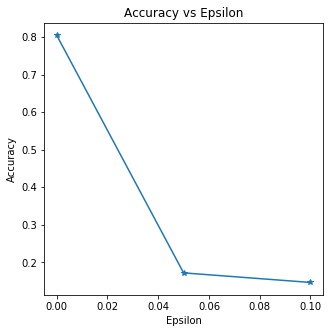

In [170]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:len(accuracies)], accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [175]:
accuracies = []
examples = []
epsilons = [0, .05, .1, .15, .2, .25, .3]
attack_method = 'stepll'

for eps in epsilons:
    acc, ex = test(model, device, testloader, criterion, attack_method, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 8046 / 8046 = 0.8046
Epsilon: 0.05	Test Accuracy = 2259 / 8046 = 0.2259
Epsilon: 0.1	Test Accuracy = 1691 / 8046 = 0.1691


KeyboardInterrupt: 

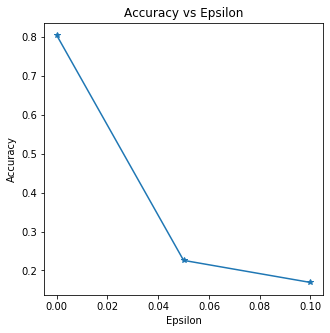

In [176]:
plt.figure(figsize=(5,5))
plt.plot(epsilons[:len(accuracies)], accuracies, "*-")
# plt.yticks(np.arange(0, 1.1, step=0.1))
# plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()